Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import

In [1]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns

# train-test split
from sklearn.model_selection import train_test_split

# 2. Load All Data

In [2]:
# LIMITED DATA
Bldg_Lim = []

# Read all building data and append to list
for path in pathlib.Path("./Data/microclimate_model/Combined/dataset2").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Lim.append(current_file)

# BIG DATA
Bldg_Big = []

# Read all building data and append to list
for path in pathlib.Path("./Data/NN_big_data").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Big.append(current_file)

## 2.1 Preprocessing

1. Adding Month, Hour, and Minute to limited data
2. Removing hours out of ENVI-met accuracy range (after 9 pm) for limited data
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx
4. Drop na rows in limited data (some data points from campus metabolism not available)
5. Drop 'index' column and rename 'rel humid' to 'rel hum' for big data

In [3]:
## LIMITED DATA ##
# Create Month, Hour, and Minute column for all dataframes in list and drop unnecessary columns
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i].Date_Time = pd.to_datetime(Bldg_Lim[i].Date_Time)
    Bldg_Lim[i]['Month'] = Bldg_Lim[i].Date_Time.dt.month
    Bldg_Lim[i]['Hour'] = Bldg_Lim[i].Date_Time.dt.hour
    Bldg_Lim[i]['Minute'] = Bldg_Lim[i].Date_Time.dt.minute
    Bldg_Lim[i]['Day'] = Bldg_Lim[i].Date_Time.dt.day
    Bldg_Lim[i] = Bldg_Lim[i].drop(columns = ['Date_Time'])

# Remove data after 9pm
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i] = Bldg_Lim[i][(Bldg_Lim[i]['Hour'] <= 20) & (Bldg_Lim[i]['Hour'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg_Lim)):
    if Bldg_Lim[i]['bldgname'][0] in cond_area:
        Bldg_Lim[i]['CHWTON/SQFT'] = Bldg_Lim[i]['CHWTON'] / cond_area[Bldg_Lim[i]['bldgname'][0]]

# Rearrange Columns
for i in range(len(Bldg_Lim)):
    cols = ['bldgname','Date','Time','Month','Day','Hour','Minute','Air Temp','Rel Hum','KW','CHWTON','CHWTON/SQFT']
    Bldg_Lim[i] = Bldg_Lim[i][cols]

# Drop NA rows in data
for i in range(len(Bldg_Lim)):
  Bldg_Lim[i] = Bldg_Lim[i].dropna()
  Bldg_Lim[i] = Bldg_Lim[i].reset_index(drop=True)

## BIG DATA ##
# Rename 'Rel Humid' to 'Rel Hum' and drop 'index' column
for i in range(len(Bldg_Big)):
  Bldg_Big[i] = Bldg_Big[i].rename(columns = {'Rel Humid': 'Rel Hum'})
  Bldg_Big[i] = Bldg_Big[i].drop(columns=['index'])

In [4]:
# Check if NA in data
for i in range(len(Bldg_Lim)):
  null_data = Bldg_Lim[i][Bldg_Lim[i].isnull().any(axis=1)]
  print(null_data)

Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON,

# 3. Single Building Analysis - Big Data

## 3.1 Select Building

In [61]:
# Ask user to select building
for i in range(len(Bldg_Big)):
    print(i, Bldg_Big[i]['bldgname'][0])

bldgnum_B = int(input("Enter the number of the building from the list above: "))

Bldg_Big[bldgnum_B]

0 Goldwater
1 Bulldog Hall
2 ISTB 2
3 Psychology North
4 Schwada COB
5 Biodesign C
6 Biodesign A
7 Psychology
8 Biodesign B
9 Noble Library
10 ISTB 4
Enter the number of the building from the list above: 7


,bldgname,Month,Day,Hour,Minute,Air Temp,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,Psychology,1,1,0,0,11.0,40.24,111.39,36.65,0.000525
1,Psychology,1,1,0,15,11.0,40.24,113.84,37.56,0.000538
2,Psychology,1,1,0,30,10.0,43.01,112.64,34.65,0.000496
3,Psychology,1,1,0,45,9.0,46.00,117.81,35.06,0.000502
4,Psychology,1,1,1,0,9.0,46.00,113.18,41.16,0.000589
...,...,...,...,...,...,...,...,...,...,...
34617,Psychology,12,31,22,0,6.0,93.30,123.36,44.78,0.000641
34618,Psychology,12,31,22,15,5.0,100.00,110.68,31.44,0.000450
34619,Psychology,12,31,22,30,5.0,100.00,109.87,16.04,0.000230
34620,Psychology,12,31,22,45,6.0,93.30,107.33,18.83,0.000270


## 3.2 EDA

### 3.2.1 Boxplots

0 bldgname
1 Month
2 Day
3 Hour
4 Minute
5 Air Temp
6 Rel Hum
7 KW
8 CHWTON
9 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 9

 ISTB 4


<AxesSubplot:title={'center':'CHWTON/SQFT'}, xlabel='Month'>

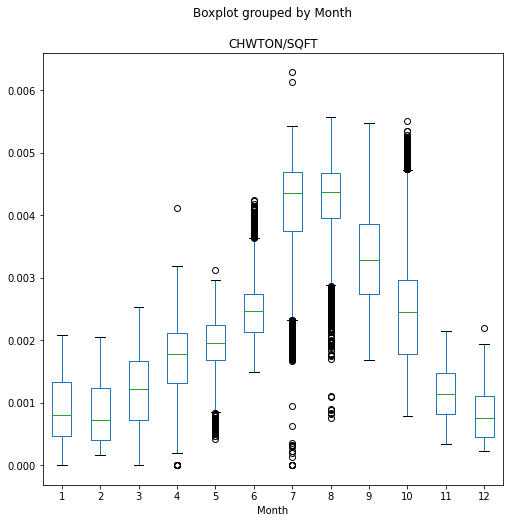

In [33]:
# Show df columns to select for boxplot
x = Bldg_Big[bldgnum_B].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Big[bldgnum_B]['bldgname'][0])
Bldg_Big[bldgnum_B].boxplot(by='Month', column=x[colname], grid = False, figsize = (8,8))

### 3.2.2 Time Series

In [9]:
### will work on create Date and Time column for big data to visualize vs Limited Data

# 4. Single Building Analysis - Limited Data

## 4.1 Select Building

In [62]:
# Ask user to select building
for i in range(len(Bldg_Lim)):
    print(i, Bldg_Lim[i]['bldgname'][0])

bldgnum_L = int(input("Enter the number of the building from the list above: "))

Bldg_Lim[bldgnum_L].head()

0 Goldwater
1 Bulldog Hall
2 ISTB 2
3 Psychology North
4 Schwada COB
5 Biodesign C
6 Biodesign A
7 Psychology
8 Biodesign B
9 Noble Library
10 ISTB 4
Enter the number of the building from the list above: 7


,bldgname,Date,Time,Month,Day,Hour,Minute,Air Temp,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,Psychology,2018-05-16,05:00,5,16,5,0,23.438443,21.523566,108.45,120.18,0.001720
1,Psychology,2018-05-16,05:15,5,16,5,15,23.914056,24.374523,108.68,129.16,0.001849
2,Psychology,2018-05-16,05:30,5,16,5,30,23.775401,23.998164,109.12,112.29,0.001607
3,Psychology,2018-05-16,05:45,5,16,5,45,23.674907,24.049482,117.51,139.02,0.001990
4,Psychology,2018-05-16,06:00,5,16,6,0,23.553148,24.308337,122.35,139.27,0.001993


## 4.2 EDA

### 4.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Rel Hum
9 KW
10 CHWTON
11 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 9

 ISTB 4


<AxesSubplot:title={'center':'KW'}, xlabel='Hour'>

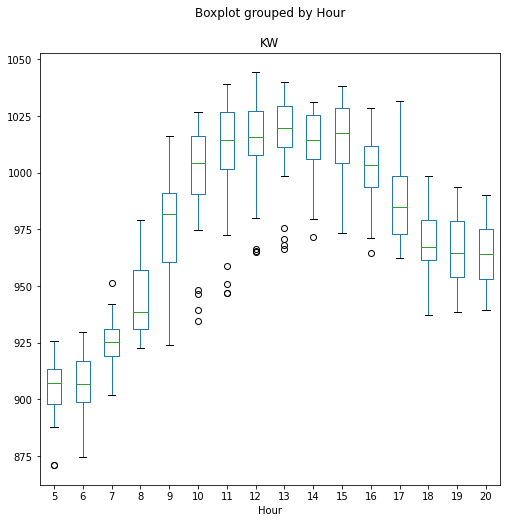

In [35]:
# Show df columns to select for boxplot
x = Bldg_Lim[bldgnum_L].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Lim[bldgnum_L]['bldgname'][0])
Bldg_Lim[bldgnum_L].boxplot(by='Hour', column=x[colname], grid = False, figsize = (8,8))

### 4.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25<br>
August: 3<br>
September: 11, 29<br>

Enter month number: 9

 2 day(s) found in Sep 

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Rel Hum
9 KW
10 CHWTON
11 CHWTON/SQFT
Enter y-axis from column list above: 10


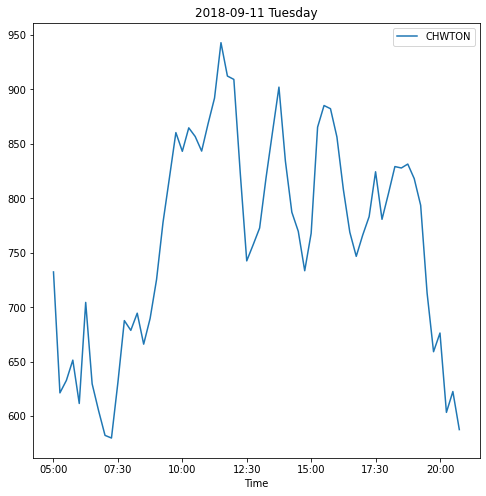

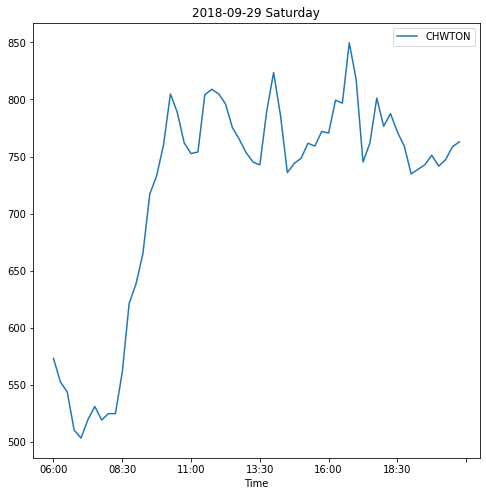

In [8]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg_Lim[bldgnum_L]['Month'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg_Lim[bldgnum_L][(Bldg_Lim[bldgnum_L]['Month'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 4.2.3 Correlation Matrix

<AxesSubplot:>

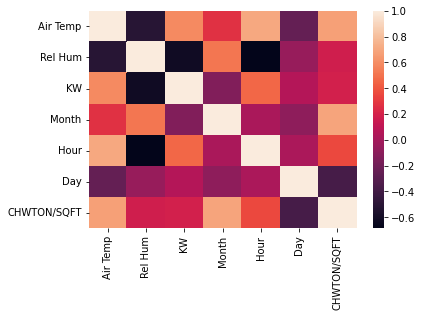

In [14]:
corr_pd = pd.DataFrame(Bldg_Lim[bldgnum_L][['Time','Air Temp','Rel Hum','KW','Month','Hour','Day', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)

# 5. Train Models on both datasets 

## 5.1 Define Generalized Model Functions

In [69]:
#using single layer ANN. Model Parameters: hidden layer- 10 neurons, output layer- 1 neuron
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
def prepare_data(dataset):
    Y = dataset['CHWTON/SQFT']
    X = dataset[['Air Temp', 'Rel Hum']]
    Y= Y.values.reshape(-1, 1)
    # create scaler
    scaler1 = StandardScaler()
    X_scaled = scaler1.fit_transform(X)
    # #do for output variables
    scaler2 = StandardScaler()
    Y_scaled = scaler2.fit_transform(Y)
    X_scaled = np.asarray(X_scaled).astype('float32')
    Y_scaled = np.asarray(Y_scaled).astype('float32')
    return X_scaled,Y_scaled

def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def define_model(activation_type, hidden_layers, kernel_initializer='he_normal', bias_initializer='he_normal', loss='mse'):
    model = Sequential()
    if activation_type == 'leaky_relu':
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal'))
        model.add(LeakyReLU(alpha=0.1))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8))
            model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(12))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(1, activation='linear'))
    else:
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal', bias_initializer='he_normal', activation=activation_type))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8, activation=activation_type))
        model.add(Dense(12, activation=activation_type))
        model.add(Dense(1, activation='linear'))
    model.compile(loss= loss, optimizer='adam', metrics = ['mse','mae'])
    return model
def fine_tune(model,loss='mse'):
    model.trainable = True
    fine_tune_at = 1
    for layer in model.layers[:fine_tune_at]:
      layer.trainable =  False
    model.compile(loss=loss, optimizer='adam', metrics = ['mse','mae'])
    return model
def plot_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
def evaluate(model,X,Y):
    #evaluate on test dataset, add evaluation parameters
    Y_preds = model.predict(X)
    RMSE = np.sqrt(metrics.mean_squared_error(Y, Y_preds))
    R2_score = metrics.r2_score(Y, Y_preds)
#     test_loss = model.evaluate(X, Y)
    return RMSE, R2_score

## 5.2 Prepare Data for feeding into training loop

In [70]:
# Limited Data
X_limited,Y_limited = prepare_data(Bldg_Lim[bldgnum_L])
X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.2, random_state=20)
X,Y = prepare_data(Bldg_Big[bldgnum_B])
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [ ]:
# X_limited_test

## 5.3 Hyperparameter Tuning experiments

In [ ]:
activation_functions = ['relu','elu','selu','leaky_relu','tanh']
no_hidden_layers = [1,3,5,7,9,11]
row_headings = ['1','3','5','7','9','11']
eval_func = []
for func in activation_functions:
    eval_func_layers = []
    for hl in no_hidden_layers:
        model = define_model(func,hl)
        history = model.fit(X_train, Y_train, batch_size=128, epochs=100,  validation_split=0.2, verbose=0)
        RMSE, _ = evaluate(model, X_test, Y_test)
        eval_func_layers.append(RMSE)
    eval_func.append(eval_func_layers)
print(eval_func)   
tab = pd.DataFrame(eval_func, activation_functions, row_headings)
print(tab)
        


## 5.4 Train Model with Optimized hyperparameters

In [71]:
base_model = define_model('relu',3,huber_loss)
history = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)

## 5.5 Evaluate Base Model with Big Dataset and Limited Dataset

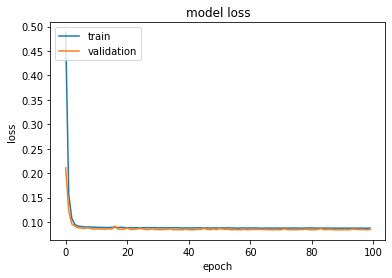

0.9085633600734783
0.7673367728499041


In [72]:
plot_curve(history)
RMSE, R2 = evaluate(base_model, X_test, Y_test)
RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
print(R2)
print(R2_base_model)

## 5.6 Transfer features and Fine Tune Base Model on Limited Dataset

In [73]:

fine_tuned_model = fine_tune(base_model)
# X_limited,Y_limited = prepare_data(envimet)
history = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=50, verbose=0)

## 5.7 Evaluate Fine-tuned Model on Limited Dataset

In [74]:
RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
print(R2_fine_tune)

0.9082637324214261


## 5.8 Implement for all Buildings and report score

In [52]:
from IPython.display import display
def model_multiple():
    ### Create dataframe and add building names ###
    rf_bld_scores = pd.DataFrame(columns = {"bldgname", "R2_score_base_model","RMSE_score_base_model", "R2_score_finetuned_model","RMSE_score_finetuned_model"})
    for i in range(len(Bldg_Lim)):
        rf_bld_scores = rf_bld_scores.append({'bldgname': Bldg_Lim[i]['bldgname'].unique()[0]}, ignore_index=True)
    rf_bld_scores.fillna(5)
    ### Append scores to all buildings ###
    for i in range(len(Bldg_Lim)):
        # drop na values if in dataframe
        if (Bldg_Lim[i].isnull().values.any() == True):
            Bldg_Lim[i] = Bldg_Lim[i].dropna()
        building_name = Bldg_Lim[i]['bldgname'][0] 
        print("Train model for "+ building_name )
        # Limited Data
        X_limited,Y_limited = prepare_data(Bldg_Lim[i])
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.2, random_state=20)
        #Big Data
        X,Y = prepare_data(Bldg_Big[i])
        X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
        base_model = define_model('relu',3)
        print("Train model for "+ building_name +" Big Data" )
        history_base = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)
        RMSE, R2 = evaluate(base_model, X_test, Y_test)
        RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
        rf_bld_scores["R2_score_base_model"][i] = R2_base_model
        rf_bld_scores["RMSE_score_base_model"][i] = RMSE_base_model   
        fine_tuned_model = fine_tune(base_model)
        print("Train model for "+ building_name +" Limited Data" )
        history_fine_tune = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=50, verbose=0)
        RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
        rf_bld_scores["R2_score_finetuned_model"][i] = R2_fine_tune
        rf_bld_scores["RMSE_score_finetuned_model"][i] = RMSE_fine_tune
        rf_bld_scores= rf_bld_scores[["bldgname", "R2_score_base_model","RMSE_score_base_model", "R2_score_finetuned_model","RMSE_score_finetuned_model"]]
    return rf_bld_scores
multiple_bldg_scores = model_multiple()
display(multiple_bldg_scores)

Train model for Goldwater
Train model for Goldwater Big Data
4/4 [==============================] - 0s 877us/step - loss: 0.0685 - mse: 0.0685 - mae: 0.2140
Train model for Goldwater Limited Data
4/4 [==============================] - 0s 688us/step - loss: 0.0329 - mse: 0.0329 - mae: 0.1364
Train model for Bulldog Hall
Train model for Bulldog Hall Big Data
4/4 [==============================] - 0s 740us/step - loss: 0.4918 - mse: 0.4918 - mae: 0.5594
Train model for Bulldog Hall Limited Data
4/4 [==============================] - 0s 624us/step - loss: 0.3450 - mse: 0.3450 - mae: 0.4654
Train model for ISTB 2
Train model for ISTB 2 Big Data
4/4 [==============================] - 0s 740us/step - loss: 0.0885 - mse: 0.0885 - mae: 0.2180
Train model for ISTB 2 Limited Data
4/4 [==============================] - 0s 696us/step - loss: 0.0360 - mse: 0.0360 - mae: 0.1472
Train model for Psychology North
Train model for Psychology North Big Data
4/4 [==============================] - 0s 763us/s

,bldgname,R2_score_base_model,RMSE_score_base_model,R2_score_finetuned_model,RMSE_score_finetuned_model
0,Goldwater,0.929674,0.261752,0.966241,0.181354
1,Bulldog Hall,0.478708,0.701296,0.634292,0.587392
2,ISTB 2,0.902833,0.297516,0.960467,0.189772
3,Psychology North,0.775595,0.463319,0.878579,0.340809
4,Schwada COB,0.850654,0.359971,0.925889,0.253579
5,Biodesign C,0.53356,0.740255,0.884803,0.367878
6,Biodesign A,0.745724,0.463249,0.895475,0.29701
7,Psychology,0.791995,0.453104,0.906788,0.303317
8,Biodesign B,0.818186,0.409846,0.935079,0.244906
9,Noble Library,0.499333,0.689066,0.777789,0.459059


<!-- Which buildings are we training for? To be decided depending on results  -->
<!-- Train for all buildings automatically and report the scores for base_model and fine_tuned_model. -->
<!-- What scores is RF reporting? RF reports the R2 score. Add R2 score to evaluators. Create a list for evaluating and then visualise it. Not a great score, needs improvements.  -->
<!-- How to visualise the results? Made comparison matrix for now -->
How to improve the results? Experiment with loss function
Automate model selection
lr scheduler
Change Y to y everywhere(Regression problem)
Add functionality to pass building names which we want to model
<!-- Dataset is ready, now fine-tune using this dataset and also compare results. Change Y to y everywhere once. 